In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import sys
sys.path.append("../../")

from src.datamodules.basic_pde import NavierStokes
from src.tasks.default import DefaultModel
from src.models.fno import NeuralOperator2d
from src.models.layers.fdm2d import DFTConv2d, DCTConv2d
from src.losses.relative_l2 import RelativeL2
from src.train import train
from src.eval import evaluate
from src.utils import utils
from src.utils.numerics import dct2d, idct2d
from run import dictconfig_filter_key

import hydra

import yaml
from omegaconf import DictConfig, OmegaConf, open_dict

%load_ext autoreload
%autoreload 2

/mpoli/kairos/notebooks/navier-stokes/../../run.py:24: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="configs/", config_name="default_config")


In [31]:
device = torch.device("cuda")
# dataset shapes (2048, 8192)
res = 64
subsampling_rate = 1
batch_size=32
signal_resolution = res / subsampling_rate

dmodule = NavierStokes('../../data/', subsampling_rate=subsampling_rate, viscosity=1e-4,
                        batch_size=batch_size, ntrain=1000, target_time=10)
dmodule.setup()

In [32]:
model = NeuralOperator2d(
    modes1=24,
    modes2=24,
    width=64,
    padding=0,
    weight_init=1,
    signal_resolution=(signal_resolution, signal_resolution),
    nlayers=6,
    residual=True,
    use_spectral=True,
    keep_high=False,
    spectral_layer=DFTConv2d, # DFT, DCT
    act="gelu"
).to(device)

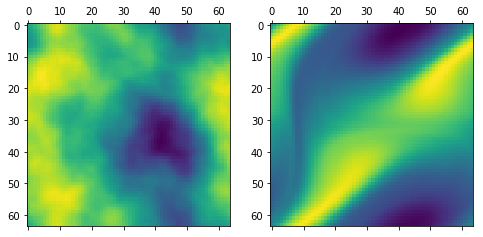

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))
for k in range(5):
    axs[0].matshow(dmodule.dataset_train.tensors[0][k]);

for k in range(5):
    axs[1].matshow(dmodule.dataset_train.tensors[1][k]);

In [34]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=100, gamma=0.5)
num_epochs = 500
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    iterator = iter(dmodule.train_dataloader())
    for k, batch in enumerate(iterator):
        x, y = batch[0], batch[1]
        x, y = x.to(device), y.to(device)
        yhat = model(x)
        loss = criterion(yhat, y)
        loss.backward()
        print(f'Epoch: {epoch}, Iter: {k}, Loss: {loss}', end='\r')
        opt.step()
        opt.zero_grad()
    sched.step()


In [37]:
sum([p.numel() for p in model.parameters()])

56656769

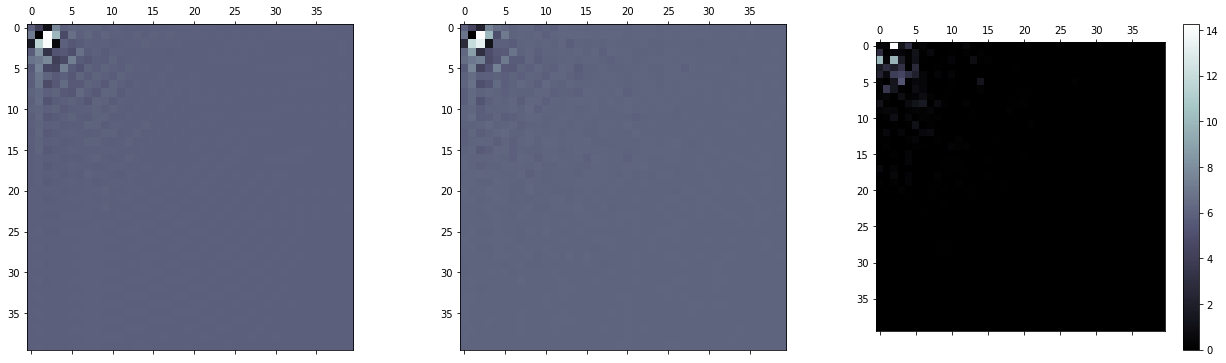

In [38]:
x, y = batch[0], batch[1]
x, y = x.to(device), y.to(device)
y = dct2d(y, norm='ortho')
yhat = model(x)#[:, :-model.padding]
yhat = dct2d(yhat, norm='ortho')

fig, axs = plt.subplots(1, 3, figsize=(22,6))
for k in range(1):
    axs[0].matshow(y[k][:40,:40].cpu(), cmap='bone'); # if using dct change here
    #axs[0].plot(torch.fft.rfft(y, norm="ortho")[k][:40].cpu(), c='b');
for k in range(1):
    axs[1].matshow(yhat[k][:40,:40].detach().cpu(), cmap='bone');
for k in range(1):
    im = axs[2].matshow((y[k][:40,:40].cpu() - yhat[k][:40,:40].detach().cpu())**2, cmap='bone');
plt.colorbar(im)

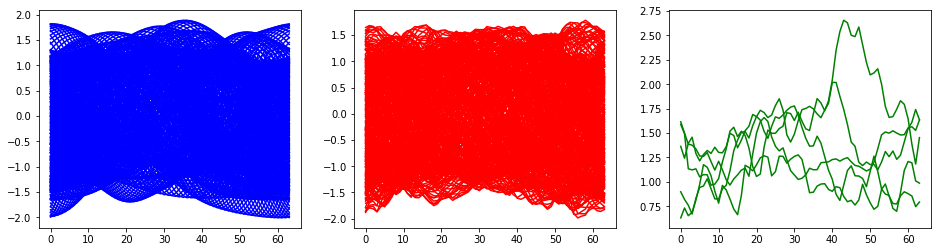

In [39]:
x, y = batch[0], batch[1]
x, y = x.to(device), y.to(device)
#y = dct2d(y, norm='ortho')
yhat = model(x)#[:, :-model.padding]
#yhat = dct2d(y, norm='ortho')

fig, axs = plt.subplots(1, 3, figsize=(16,4))
for k in range(5):
    axs[0].plot(y[k].cpu(), c='b'); # if using dct change here
    #axs[0].plot(torch.fft.rfft(y, norm="ortho")[k][:40].cpu(), c='b');
for k in range(5):
    axs[1].plot(yhat[k].detach().cpu(), c='r');
for k in range(5):
    axs[2].plot(torch.norm(y[k].cpu() - yhat[k].detach().cpu(), dim=(-2)), c='g');

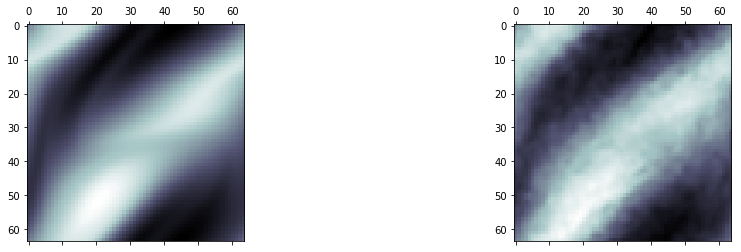

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(16,4))
for k in range(4):
    axs[0].matshow(y[k].cpu(), cmap='bone');

for k in range(4):
    axs[1].matshow(yhat[k].detach().cpu(), cmap='bone');